# Imports

In [40]:
import pandas as pd
import numpy as np

from mamimo.time_utils import add_time_features, PowerTrend
from mamimo.carryover import ExponentialCarryover
from mamimo.saturation import ExponentialSaturation, BoxCoxSaturation

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import scipy.stats as stats

import holidays

import seaborn as sns
import matplotlib.pyplot as plt

# Load DataFrame

In [41]:

df = pd.read_csv('../../raw_data/df.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df['day'] = df.index # we will use this in our column transformer
df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks'])

In [42]:
df

,orders,total_sales,facebook,google,tiktok,day
Day,,,,,,
2021-07-01,10,414.85,257.01,1.17,0.00,2021-07-01
2021-07-02,6,229.95,250.30,0.84,0.00,2021-07-02
2021-07-03,10,459.89,248.59,0.72,0.00,2021-07-03
2021-07-04,17,508.36,258.05,0.07,0.00,2021-07-04
2021-07-05,13,399.88,257.47,0.38,0.00,2021-07-05
...,...,...,...,...,...,...
2023-08-20,294,13616.97,2148.53,466.56,368.86,2023-08-20
2023-08-21,356,15348.42,2210.01,400.58,391.14,2023-08-21
2023-08-22,150,6054.53,1335.84,289.46,218.61,2023-08-22


# Split Data

In [43]:
n_splits = 5  # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]


y_train = train_df['total_sales']
X_train = train_df.drop(columns = ['total_sales', 'orders'])


y_test = test_df['total_sales']
X_test = test_df.drop(columns = ['total_sales', 'orders'])

# Create Custom Tranformers

## Time Features

### Holidays

In [44]:
class AddHolidaysTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        de_holiday_list = []
        for holiday in holidays.Germany(years=[2021,2022,2023]).items():
            de_holiday_list.append(holiday)
        de_holidays_df = pd.DataFrame(de_holiday_list, columns=["date", "holiday"])
        de_holidays_df['date'] = pd.to_datetime(de_holidays_df['date'])
        de_holidays_df.set_index('date', inplace=True)
        
        at_holiday_list = []
        for holiday in holidays.Austria(years=[2021,2022,2023]).items():
            at_holiday_list.append(holiday)
        at_holidays_df = pd.DataFrame(at_holiday_list, columns=["date", "holiday"])
        at_holidays_df['date'] = pd.to_datetime(at_holidays_df['date'])
        at_holidays_df.set_index('date', inplace=True)

        # add DE holidays to df
        merged_df = df.merge(de_holidays_df, how='left', left_index=True, right_index=True)
        merged_df['de_holiday'] = merged_df.index.isin(de_holidays_df.index).astype(int)
        merged_df.drop(columns=['holiday'], inplace=True)
        
        # add AT holidays to df
        at_holidays_df['at_holiday'] = 1 # add a 1 column to austrian holidays dataframe to help us merge with DE holidays
        merged_df = merged_df.merge(at_holidays_df[['at_holiday']], how='left', left_index=True, right_index=True)
        merged_df.head() # creates two columns (at_holiday_x, at_holiday_y), we only need one
        merged_df['at_holiday'].fillna(0, inplace=True) # replace NaN (no holiday) with 0
        merged_df['at_holiday'] = merged_df['at_holiday'].astype(int) # convert 1 and 0 to integers
        
        # combine columns
        merged_df['holiday'] = (merged_df['at_holiday'] | merged_df['de_holiday']).astype(int)
        merged_df = merged_df.drop(columns = ['de_holiday', 'at_holiday']) # drop individual DE and AT rows
        
        return merged_df[['holiday']]#.reset_index(drop=True)


#### Does it work?

In [45]:
holidays_transformer = AddHolidaysTransformer()
df = train_df.copy()
holidays_transformer.fit_transform(df)

,holiday
Day,
2021-07-01,0
2021-07-02,0
2021-07-03,0
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,0


#### Yes!

### Weekends

In [46]:
class AddWeekendsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        weekday_values = df.index.weekday
        df['fri_sat'] = ((weekday_values == 4) | (weekday_values == 5)).astype(int)
        return df[['fri_sat']]

#### Does it work?

In [47]:
weekends_transformer = AddWeekendsTransformer()
df = train_df.copy()
weekends_transformer.fit_transform(df)

,fri_sat
Day,
2021-07-01,0
2021-07-02,1
2021-07-03,1
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,1


#### Yes!

### Cyclical months

In [48]:
class AddMonthsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df = (df
        .pipe(add_time_features, month=True)
        )
        
        months_in_a_year = 12

        df['sin_MonthYear'] = np.sin(2*np.pi*(df['month'])/months_in_a_year)
        df['cos_MonthYear'] = np.cos(2*np.pi*(df['month'])/months_in_a_year)
        df.drop(columns=['month'], inplace=True)
        
        return df[['sin_MonthYear', 'cos_MonthYear']]

#### Does it work?

In [49]:
add_months_transformer = AddMonthsTransformer()
df = train_df.copy()
add_months_transformer.fit_transform(df)

,sin_MonthYear,cos_MonthYear
Day,,
2021-07-01,-0.500000,-0.866025
2021-07-02,-0.500000,-0.866025
2021-07-03,-0.500000,-0.866025
2021-07-04,-0.500000,-0.866025
2021-07-05,-0.500000,-0.866025
...,...,...
2023-04-12,0.866025,-0.500000
2023-04-13,0.866025,-0.500000
2023-04-14,0.866025,-0.500000


#### Yes!

# Instantiate Custom Transformers

In [50]:
holidays_transformer = AddHolidaysTransformer()
weekends_transformer = AddWeekendsTransformer()
add_months_transformer = AddMonthsTransformer()

## Time CT

In [51]:
time_features = ColumnTransformer(
    [
     ('holidays_pipe', Pipeline([
            ('add_holidays', AddHolidaysTransformer())
     ]), ['day']),
     ('weekends_pipe', Pipeline([
            ('add_weekends', AddWeekendsTransformer())
     ]), ['day']),
     ('months_pipe', Pipeline([
            ('add_months', AddMonthsTransformer())
     ]), ['day'])
], remainder = 'passthrough')

In [54]:
df = train_df.copy()
transformed_df = time_features.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns = ['holiday', 'weekends', 'sin', 'cos'])
transformed_df

ValueError: Shape of passed values is (655, 9), indices imply (655, 4)

#### It works!

# Pipeline

In [ ]:
model = LinearRegression()

time_preprocessing = Pipeline([
    ('time_features', time_features)
])

union = FeatureUnion([
    ('time_preprocessing', time_preprocessing)
])

pipeline = Pipeline([
    ('union', union),
    ('model', model)
])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('time_preprocessing',
                                                 Pipeline(steps=[('time_features',
                                                                  ColumnTransformer(remainder='passthrough',
                                                                                    transformers=[('holidays_pipe',
                                                                                                   Pipeline(steps=[('add_holidays',
                                                                                                                    AddHolidaysTransformer())]),
                                                                                                   ['day']),
                                                                                                  ('weekends_pipe',
                                                                                                   Pipeline(steps=[('add_weekends',
                                                                                                                    AddWeekendsTransformer())]),
                                                                                                   ['day']),
                                                                                                  ('months_pipe',
                                                                                                   Pipeline(steps=[('add_months',
                                                                                                                    AddMonthsTransformer())]),
                                                                                                   ['day'])]))]))])),
                ('model', LinearRegression())])

In [ ]:
pipe_df = pd.DataFrame(pipeline[0].transform(X_train))
#pipe_df.columns = ['holiday','weekend', 'sin_months', 'cos_months', 'facebook', 'google', 'tiktok']
pipe_df

,0,1,2,3,4,5,6,7
0,0.0,0.0,-0.500000,-0.866025,257.01,1.17,0.00,0.0
1,0.0,1.0,-0.500000,-0.866025,250.30,0.84,0.00,0.0
2,0.0,1.0,-0.500000,-0.866025,248.59,0.72,0.00,0.0
3,0.0,0.0,-0.500000,-0.866025,258.05,0.07,0.00,0.0
4,0.0,0.0,-0.500000,-0.866025,257.47,0.38,0.00,0.0
...,...,...,...,...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000,885.33,208.52,209.03,0.0
651,0.0,0.0,0.866025,-0.500000,882.17,186.47,208.82,0.0
652,0.0,1.0,0.866025,-0.500000,662.08,160.69,216.38,0.0
653,0.0,1.0,0.866025,-0.500000,481.71,149.16,239.65,0.0


# Predicted vs. Observed Values

## Train Set

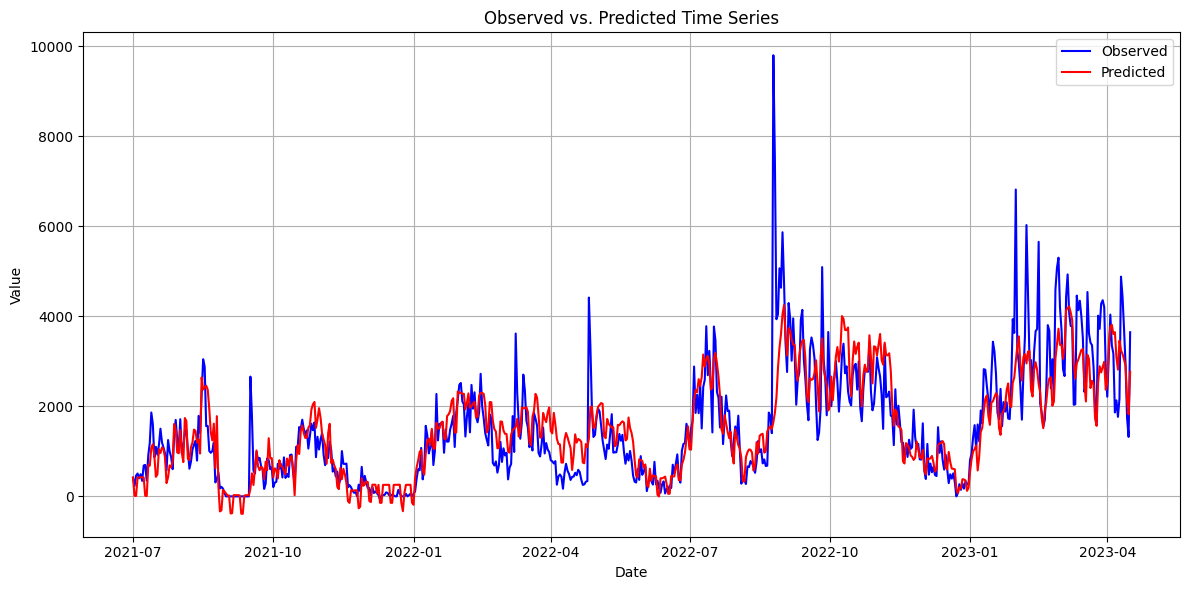

In [ ]:
# Extract the date index, observed values, and predicted values
date_index = train_df.index
y_true = train_df['total_sales']
y_pred = best_pipeline.predict(train_df)

# Create a line plot for observed values (blue)
plt.figure(figsize=(12, 6))  # Optional: Adjust the figure size
plt.plot(date_index, y_true, linestyle='-', color='blue', label='Observed')

# Create a line plot for predicted values (red)
plt.plot(date_index, y_pred, linestyle='-', color='red', label='Predicted')

# Customize the plot
plt.title('Observed vs. Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

# Add a legend to differentiate between observed and predicted lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Test Set

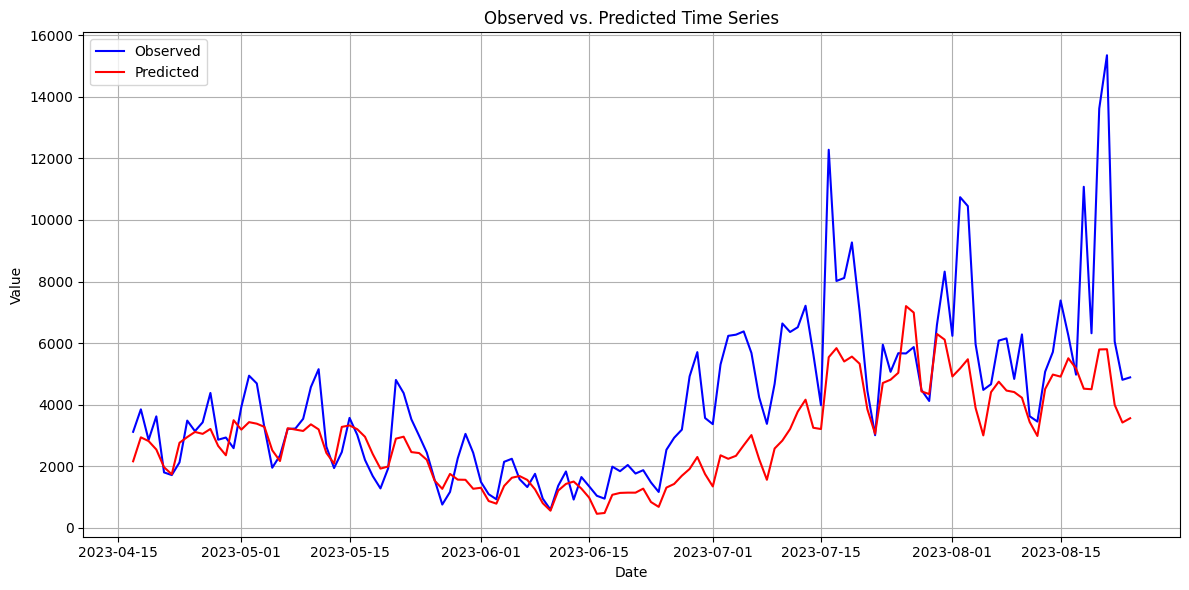

In [ ]:
# Extract the date index, observed values, and predicted values
date_index = test_df.index
y_true = test_df['total_sales']
y_pred = best_pipeline.predict(test_df)

# Create a line plot for observed values (blue)
plt.figure(figsize=(12, 6))  # Optional: Adjust the figure size
plt.plot(date_index, y_true, linestyle='-', color='blue', label='Observed')

# Create a line plot for predicted values (red)
plt.plot(date_index, y_pred, linestyle='-', color='red', label='Predicted')

# Customize the plot
plt.title('Observed vs. Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

# Add a legend to differentiate between observed and predicted lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
start_date = '2023-06-18'
end_date = '2023-07-01'
# Select the date range
selected_range = test_df.loc[start_date:end_date]
# Find the date on which the minimum value occurred
date_of_max = selected_range['total_sales'].idxmin()
date_of_max

Timestamp('2023-06-24 00:00:00')

## Check pipeline output

In [ ]:
pipe_df = pd.DataFrame(best_pipeline[0].transform(X_train))
pipe_df.columns = ['holiday','weekend', 'sin_months', 'cos_months', 'spike', 'adstock_fb', 'adstock_gg', 'adstock_tt']
pipe_df

,holiday,weekend,sin_months,cos_months,spike,adstock_fb,adstock_gg,adstock_tt
0,0.0,0.0,-0.500000,-0.866025,0.0,418.260462,8.767484,6.636967
1,0.0,1.0,-0.500000,-0.866025,0.0,406.556631,9.289482,6.636967
2,0.0,1.0,-0.500000,-0.866025,0.0,403.578832,9.009530,6.636967
3,0.0,0.0,-0.500000,-0.866025,0.0,420.077152,8.532172,6.636967
4,0.0,0.0,-0.500000,-0.866025,0.0,419.063910,8.322080,6.636967
...,...,...,...,...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000,0.0,1599.331780,352.996129,92.004704
651,0.0,0.0,0.866025,-0.500000,0.0,1593.099275,317.282502,91.910878
652,0.0,1.0,0.866025,-0.500000,0.0,1164.915382,276.794904,93.334215
653,0.0,1.0,0.866025,-0.500000,0.0,824.299353,245.577795,98.529702
